<a href="https://colab.research.google.com/github/andreacangiani/NMPDE2025/blob/main/python/C3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Difference for 1D reaction-advection-diffusion problem

1. Finite Difference solver for the reaction-advection-diffusion problem with nonconstant coefficients:

$-\alpha(x) u''(x)+\beta(x) u'(x)+\gamma(x) u(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$.

Implement FD method including the boundary conditions in the system.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 1D FD algebric system

In [4]:
def FD1D(omega,N,alpha,beta,gamma,rhs):
  """FD system matrix and rhs for diffusion-advection-reaction problem with coeffs alpha,beta,gamma,rhs homogeneous Dirichlet bc uniform grid in sparse CSR format"""

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute coeffs and rhs values
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)
  F = rhs(x)

  # assemble system matrix
  diff_term = [-diff[1:N+1], 2*diff, -diff[0:-1]]
  conv_term = [-conv[1:N+1], conv[0:-1]]

  A = (1./h**2) * sp.diags(diff_term,[-1,0,1],format="csr")+(1./(2*h)) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac,0,format="csr")

  # modify system to account for homogeneous Dirichlet boundary conditions
  A[0,0] = 1; A[0,1] = 0; F[0] = 0
  A[N,N] = 1; A[N,N-1] = 0; F[N] = 0

  return A, F

Solve the boundary value problem with:

$a=0,\, b=Π$

$\alpha(x)=1+\sin(x),\,  \beta(x)=1,\, \gamma(x)=x,\, f(x)=1$

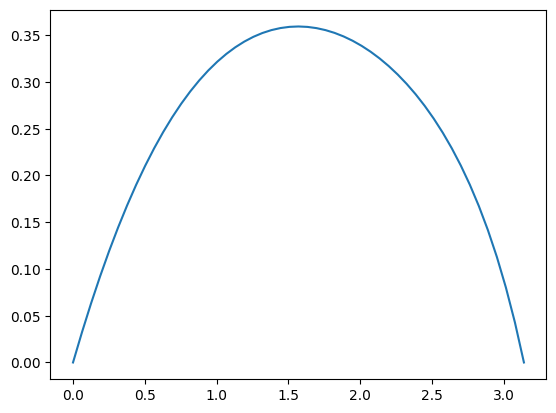

In [5]:
# Problem domain
omega =[0, np.pi]

# Problem data
alpha = lambda x : 1 + np.sin(x)
beta = lambda x : np.ones(len(x))
gamma = lambda x : x
rhs = lambda x : np.ones(len(x))

# Grid parameters
N = 50
x =np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)

# solve
uh = sp.linalg.spsolve(A,F)

# plot solution
plt.plot(x,uh)


Compute experimental order of convergence (EOC) using knowledge that

$|| U-U_h ||_\infty \approx C h^k$

with $C$ independent of $h$. Hence,

$\frac{|| U-U_{h_1} ||_\infty}{|| U-U_{h_2} ||_\infty}\approx\large(\frac{h_1}{h_2}\large)^k$,

and then,

$k\approx\frac{\log || U-U_{h_1} ||_\infty-\log|| U-U_{h_2} ||_\infty}{\log h_1 - \log h_2}$.

Notice that to estimate the EOC you need to run at least two experiments, for instance with $h_1=h$, $h_2=h/2$.

For simplicity, let's take

$\alpha(x)=1,\,  \beta(x)=0,\, \gamma(x)=0$

and

$u=\sin(x)$ so that $f=\sin(x)$


N: 10  Error: 0.0082654169662284  Rate: 1.949117024296594
N: 20  Error: 0.0020587067645332358  Rate: 2.005349249284497
N: 40  Error: 0.0005142004781475418  Rate: 2.001335495008629
N: 80  Error: 0.00012852038354571604  Rate: 2.0003337603239038
N: 160  Error: 3.2128237817063976e-05  Rate: 2.0000834328344603
N: 320  Error: 8.03194329468404e-06  Rate: 2.0000208643954394
N: 640  Error: 2.0079784173177018e-06  Rate: 2.000005321316897
N: 1280  Error: 5.019945084061561e-07  Rate: 2.000000275676347
N: 2560  Error: 1.2550042538528317e-07  Rate: 1.9999793276108875
N: 5120  Error: 3.1377531239940026e-08  Rate: 1.999888502471435
N: 10240  Error: 7.839531135367395e-09  Rate: 2.0008925689287156
N: 20480  Error: 1.9413302076998207e-09  Rate: 2.0137218405820185
N: 40960  Error: 5.0858350864047e-10  Rate: 1.9324889450273477
N: 81920  Error: 5.480762510501336e-10  Rate: -0.1078919400733849
N: 163840  Error: 8.979815779852629e-10  Rate: -0.7123092265620609
N: 327680  Error: 1.8215976504976084e-09  Rate: -

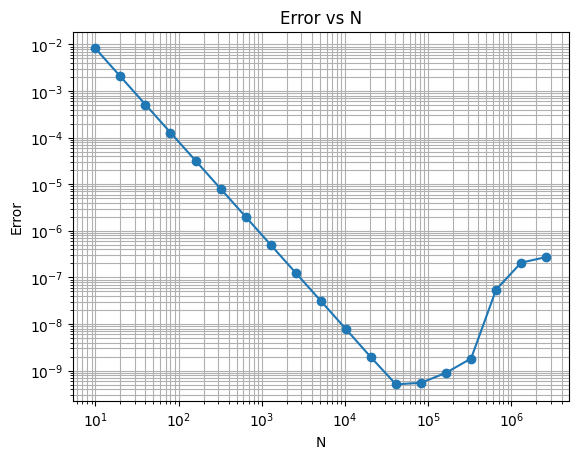

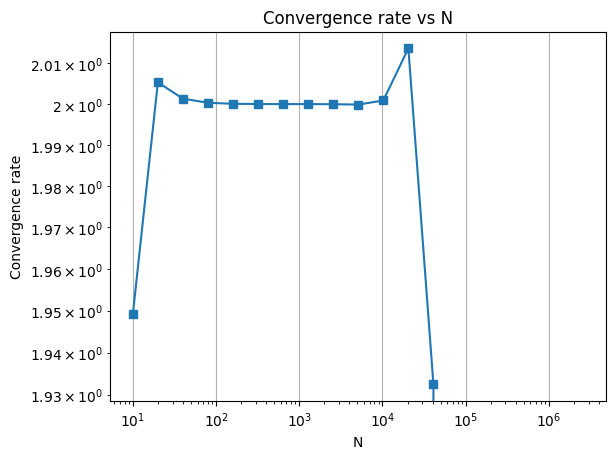

In [6]:
# Problem domain
omega =[0, np.pi]

# Problem data
alpha = lambda x : np.ones(len(x))
beta = lambda x : 0. * np.ones(len(x))
gamma = lambda x : 0. * np.ones(len(x))
rhs = lambda x : np.sin(x)
u = lambda x : np.sin(x)

# Number of experiments
no_exp = 20

# initialise with first experiment
# Grid parameters
N=5
x =np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)

# solve
uh=sp.linalg.spsolve(A,F)

# compute error
err1 = max(abs(u(x)-uh))
h1 = (omega[1]-omega[0])/N

errors = []
rates = []
Ns = [N]

# loop over remaining experiments
for i in range(no_exp-1):
  # fix the mesh
  N = 2 * N
  x =np.linspace(omega[0],omega[1],N+1)
  # evaluate system for given N
  A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
  # Solve
  uh=sp.linalg.spsolve(A,F)
  # Compute error
  err2 = max(abs(u(x)-uh))
  h2 = (omega[1]-omega[0])/N
  rate = (np.log(err1)-np.log(err2))/(np.log(h1)-np.log(h2))
  errors.append(err2)
  rates.append(rate)
  Ns.append(N)
  # Update
  err1=err2
  h1=h2

for i in range(len(errors)):
  print("N:",Ns[i+1], " Error:", errors[i], " Rate:", rates[i])

import matplotlib.pyplot as plt
plt.figure()
plt.loglog(Ns[1:], errors, marker='o')
plt.xlabel('N')
plt.ylabel('Error')
plt.title('Error vs N')
plt.grid(True, which='both')

plt.figure()
plt.loglog(Ns[1:], rates, marker='s')
plt.xlabel('N')
plt.ylabel('Convergence rate')
plt.title('Convergence rate vs N')
plt.grid(True)
plt.show()


What if the exact solution is not known? Then we can still estiate the EOC but three experiments. Indeed, letting $h_2=\theta h_1$, we have

$|| U_{h_2}-U_{h_1} ||_\infty\le || U-U_{h_1} ||_\infty + || U-U_{h_2} ||_\infty\approx C h_1^k+C h_2^k \approx C (1+\theta^k) h_1^k$

Now, given also $h_3 = \theta h_2$, we have similarly

$|| U_{h_3}-U_{h_2} ||_\infty \le C (1+\theta^k) h_2^k=C (1+\theta^k)\theta^k h_1^k$

hence,

$\frac{|| U_{h_2}-U_{h_1} ||_\infty}{|| U_{h_3}-U_{h_2} ||_\infty}\approx \frac{C (1+\theta^k) h_1^k}{C (1+\theta^k)\theta^k h_1^k}=\theta^{-k}$

from which $k$ can be estimated as before by passing to the logs.

NOTE! The discrete solutions are defined at different sets of points so the above comparison is to be intended on the set of common points!

**Exercise 1:** try this out for the problem with

$\alpha(x)=1+\sin(x),\,  \beta(x)=1,\, \gamma(x)=x, \, f=1$.

Check that you still get the expected rate of convergence.

N: 20  Error: 0.002409225155420913  Rate: 1.7974545275257314
N: 40  Error: 0.0006312672717915246  Rate: 1.932246366441191
N: 80  Error: 0.0001605605357955786  Rate: 1.9751336200169787
N: 160  Error: 4.027594478106522e-05  Rate: 1.9951269993899685
N: 320  Error: 1.00807611866649e-05  Rate: 1.998313852445989
N: 640  Error: 2.520709649483921e-06  Rate: 1.9997027246145653
N: 1280  Error: 6.302108528644101e-07  Rate: 1.9999234451234134
N: 2560  Error: 1.5755578133824777e-07  Rate: 1.9999719057741676
N: 5120  Error: 3.938874779119139e-08  Rate: 2.000007235419819
N: 10240  Error: 9.84716297391941e-09  Rate: 2.00000351237748
N: 20480  Error: 2.4598604819736636e-09  Rate: 2.001131644124221
N: 40960  Error: 6.289034570894358e-10  Rate: 1.9676660200731526
N: 81920  Error: 1.3967094147915304e-10  Rate: 2.1708066666669983
N: 163840  Error: 1.4065937303797682e-10  Rate: -0.010173792443417881
N: 327680  Error: 6.81917189382375e-10  Rate: -2.2773908600770114
N: 655360  Error: 7.937784873845999e-10  Ra

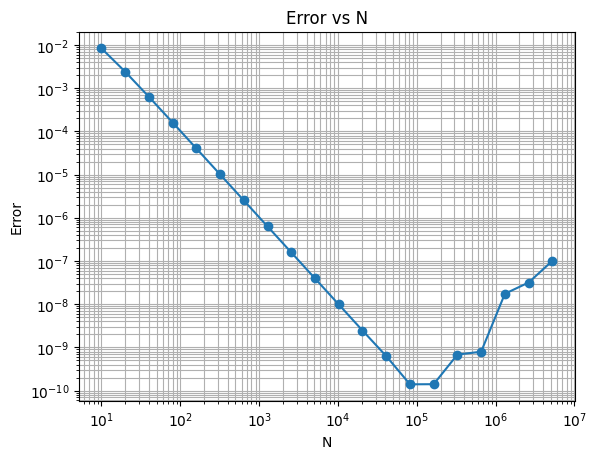

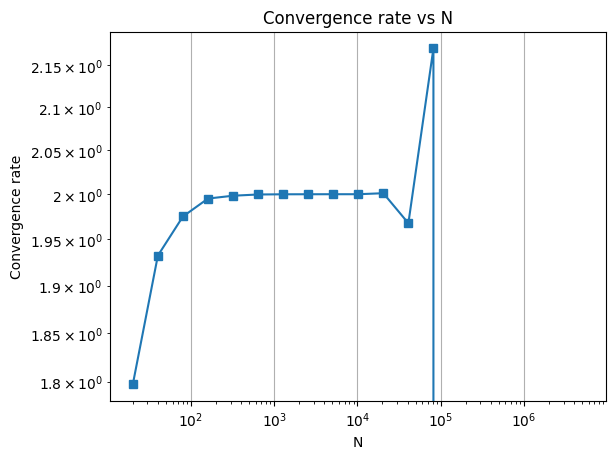

In [7]:
# Problem domain
omega =[0, np.pi]

# Problem data
alpha = lambda x : 1 + np.sin(x)
beta = lambda x : np.ones(len(x))
gamma = lambda x : x
rhs = lambda x : np.ones(len(x))

# Number of experiments
no_exp = 20

# initialise with first experiment
# Grid parameters
N = 5
x = np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
uh1 = sp.linalg.spsolve(A,F)
h1 = (omega[1]-omega[0])/N

N = N*2
A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
uh2 = sp.linalg.spsolve(A,F)
h2 = (omega[1]-omega[0])/N

err1 = max(abs(uh1-uh2[[2*i for i in range(N//2+1)]]))

uh1 = uh2
h1 = h2

errors = []
errors.append(err1)
rates = []
Ns = [N]

# loop over remaining experiments
for i in range(no_exp-1):
  # fix the mesh
  N = 2 * N
  x =np.linspace(omega[0],omega[1],N+1)
  # evaluate system for given N
  A, F = FD1D(omega,N,alpha,beta,gamma,rhs)
  # Solve
  uh2 = sp.linalg.spsolve(A,F)

  err2 = max(abs(uh1-uh2[[2*i for i in range(N//2 + 1)]]))
  h2 = (omega[1]-omega[0])/N
  rate = (np.log(err1)-np.log(err2))/(np.log(h1)-np.log(h2))
  errors.append(err2)
  rates.append(rate)
  Ns.append(N)
  # Update
  err1=err2
  h1=h2
  uh1=uh2


for i in range(len(rates)):
   print("N:",Ns[i+1], " Error:", errors[i+1], " Rate:", rates[i])

import matplotlib.pyplot as plt
plt.figure()
plt.loglog(Ns, errors, marker='o')
plt.xlabel('N')
plt.ylabel('Error')
plt.title('Error vs N')
plt.grid(True, which='both')

plt.figure()
plt.loglog(Ns[1:], rates, marker='s')
plt.xlabel('N')
plt.ylabel('Convergence rate')
plt.title('Convergence rate vs N')
plt.grid(True)
plt.show()

**Exersie 2.** Modify the FD1D routine to solve problems with nonhomogeneous boundary conditions.

In [8]:
def FD1DNH(omega,N,alpha,beta,gamma,rhs,u_a,u_b):
  """FD system matrix and rhs for diffusion-advection-reaction problem with coeffs alpha,beta,gamma,rhs non homogeneous bc uniform grid in sparse CSR format"""

  # grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)

  # compute coeffs and rhs values
  diff = alpha(x)
  conv = beta(x)
  reac = gamma(x)
  F = rhs(x)

  # assemble system matrix
  diff_term = [-diff[1:N+1], 2*diff, -diff[0:-1]]
  conv_term = [-conv[1:N+1], conv[0:-1]]

  A = (1./h**2) * sp.diags(diff_term,[-1,0,1],format="csr")+(1./(2*h)) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac,0,format="csr")

  # modify system to account for non homogeneous Dirichlet boundary conditions
  A[0,0] = 1; A[0,1] = 0; F[0] = u_a
  A[N,N] = 1; A[N,N-1] = 0; F[N] = u_b

  return A, F

**Exersie 3.** Consider now the problem defined by:

$a=0$, $b=1$, $u(0)=1$, $u(1)=0$ $f=0$ and

$\alpha=\beta=\gamma=1$.

Solve this problem using a grid made of $N=10$ intervals and plot the solution.

Next, try with $\alpha=0.01$, $\beta=1$, $\gamma=0$. What happens? Can you explain? Experiment by taking finer grids.

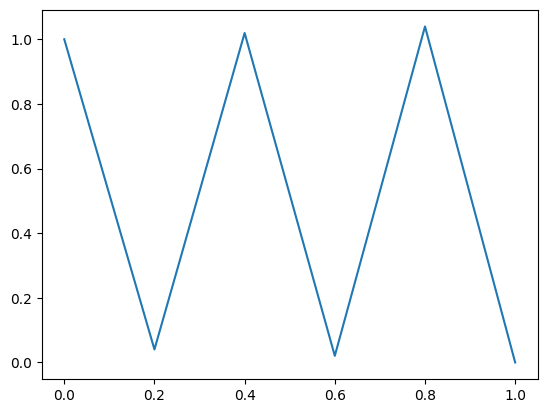

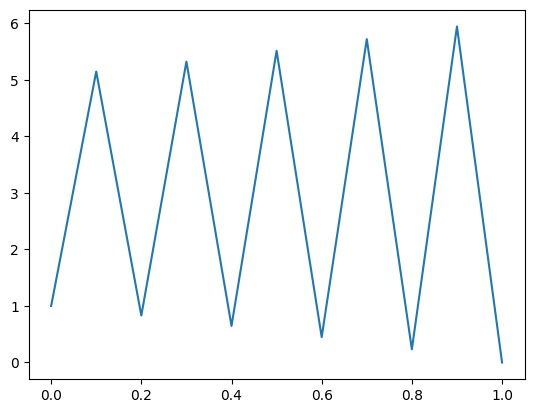

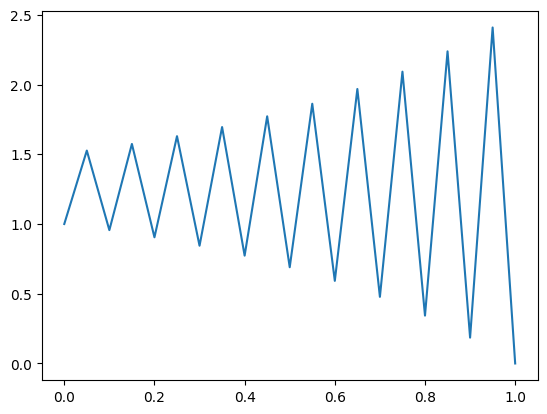

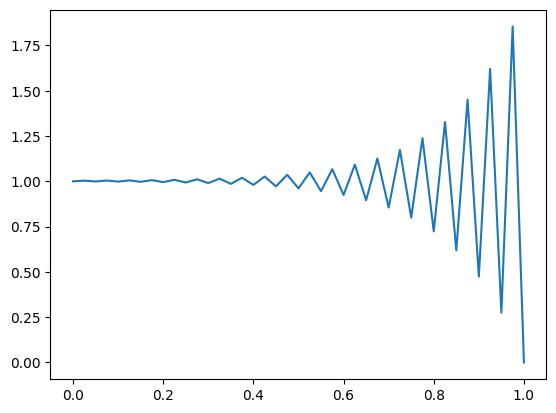

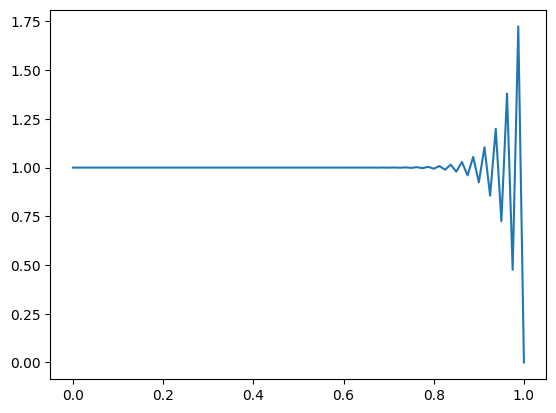

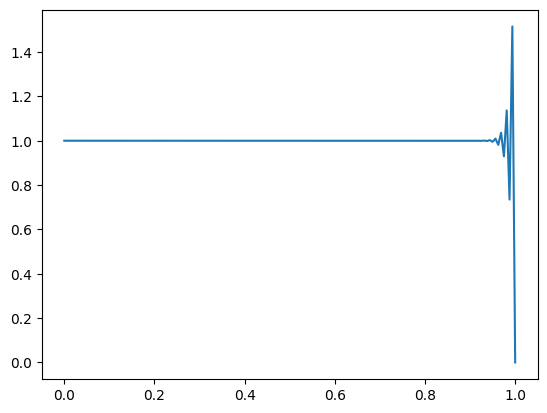

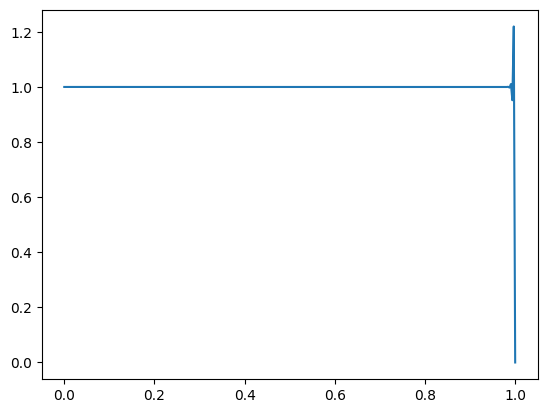

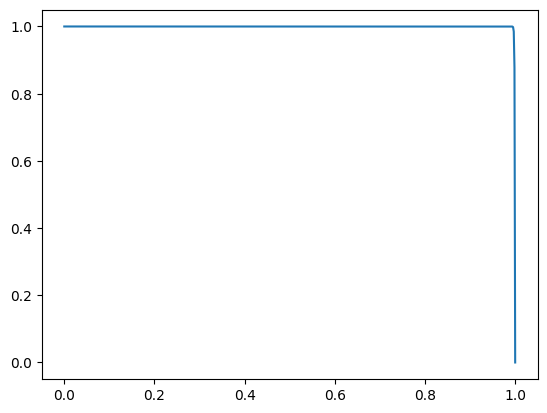

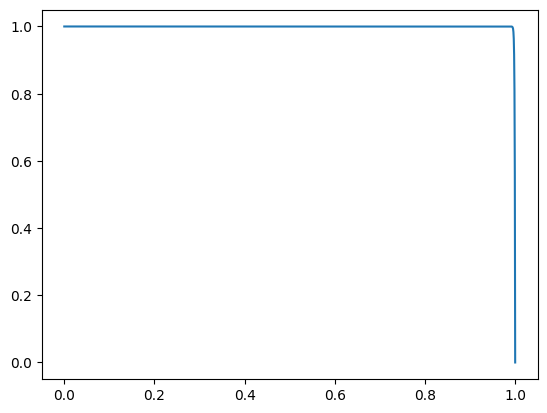

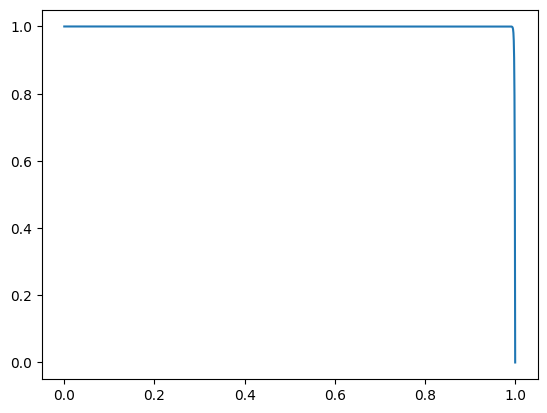

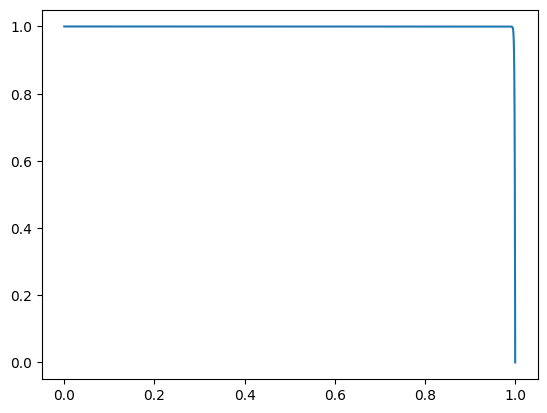

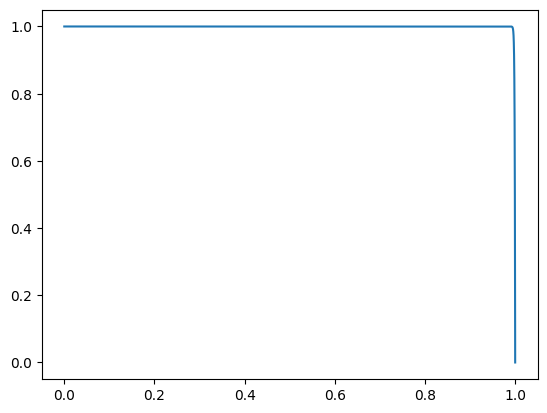

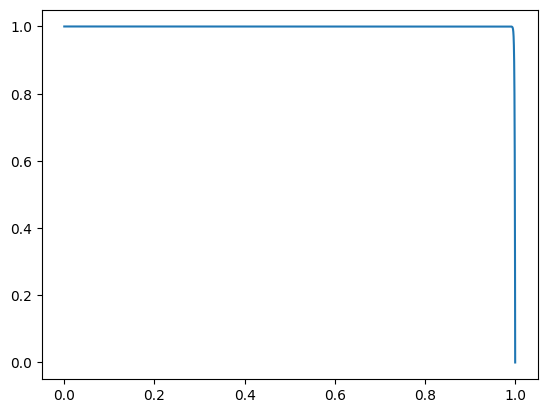

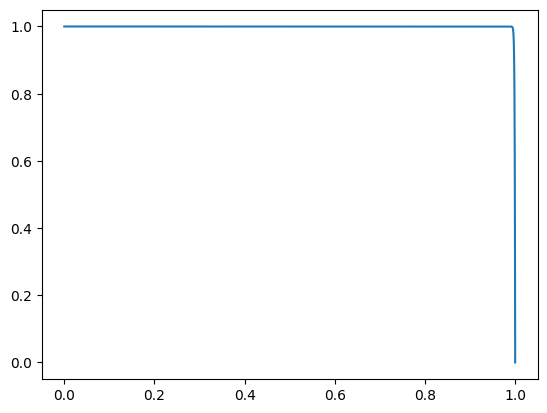

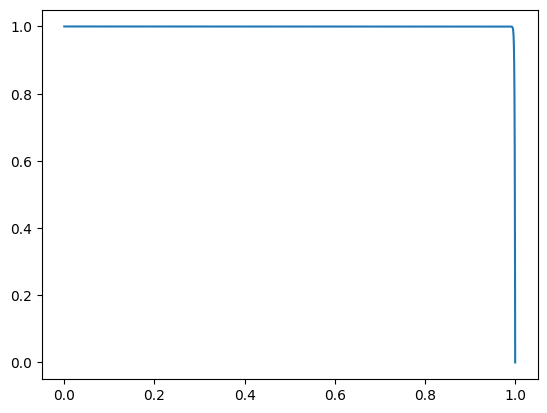

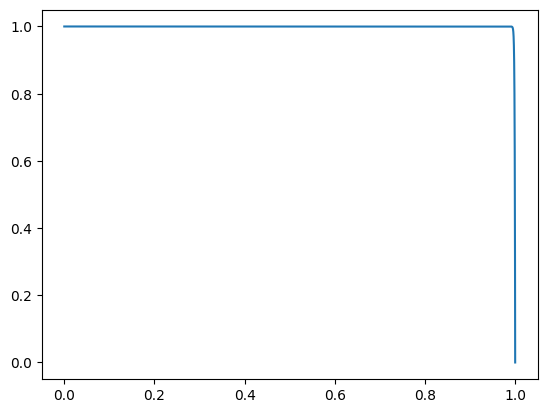

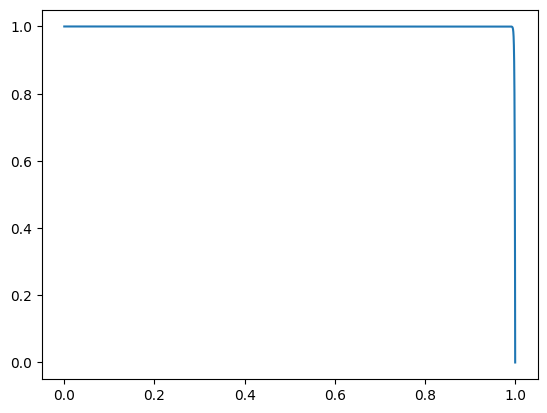

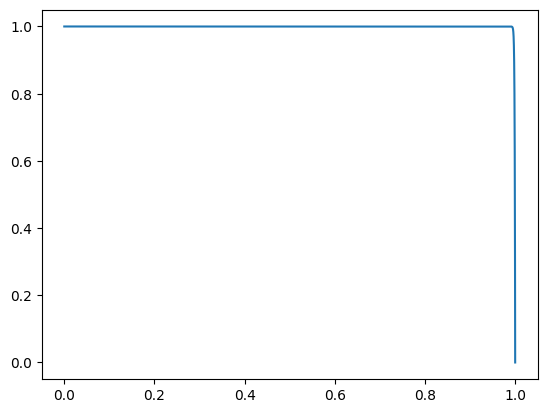

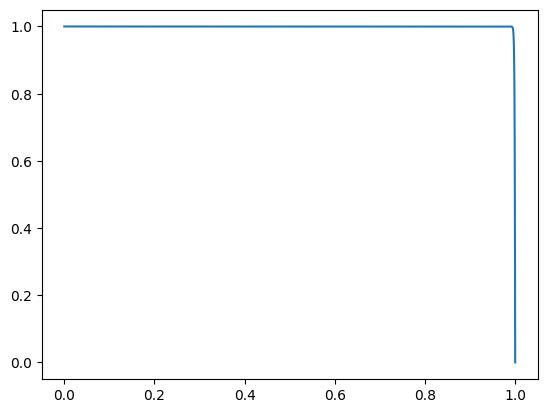

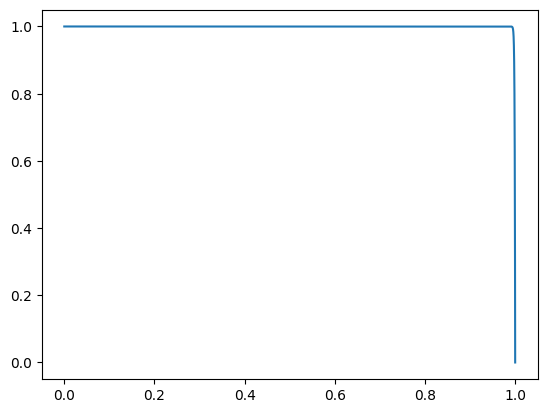

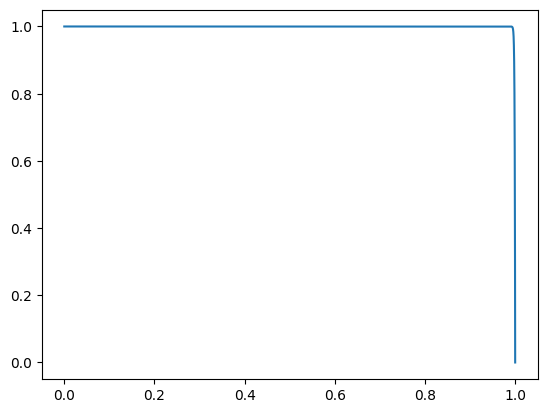

N: 20  Error: 5.761583150917142  Rate: -2.8369820566420523
N: 40  Error: 2.1342392544276243  Rate: 1.4327433701141459
N: 80  Error: 1.379267650291202  Rate: 0.629819472986641
N: 160  Error: 0.9895190146079111  Rate: 0.47910310705655657
N: 320  Error: 0.5633371189587714  Rate: 0.8127288947654928
N: 640  Error: 0.23459375868007737  Rate: 1.2638339043522766
N: 1280  Error: 0.06921419189969402  Rate: 1.7610248431443505
N: 2560  Error: 0.014999512815545013  Rate: 2.206152240287259
N: 5120  Error: 0.0035304206023235585  Rate: 2.087003666083292
N: 10240  Error: 0.000881445074238596  Rate: 2.00189749317088
N: 20480  Error: 0.00021949814904864695  Rate: 2.005661899173231
N: 40960  Error: 5.482102660059329e-05  Rate: 2.0014075240508262
N: 81920  Error: 1.370607617789954e-05  Rate: 1.9999137343207423
N: 163840  Error: 3.4284434657916307e-06  Rate: 1.9991899727652684
N: 327680  Error: 8.652232158512518e-07  Rate: 1.9864094510770294
N: 655360  Error: 2.524178583929171e-07  Rate: 1.7772583928853327


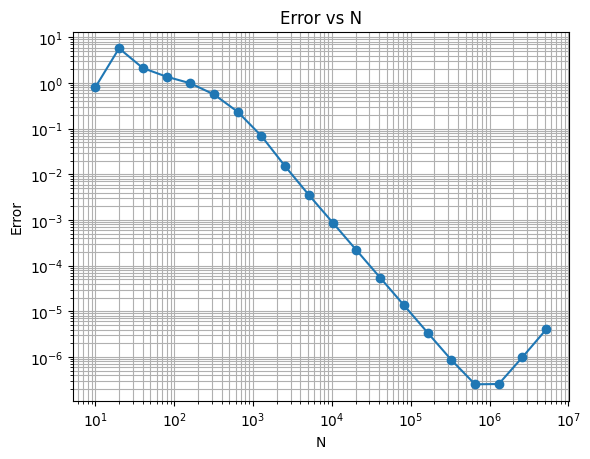

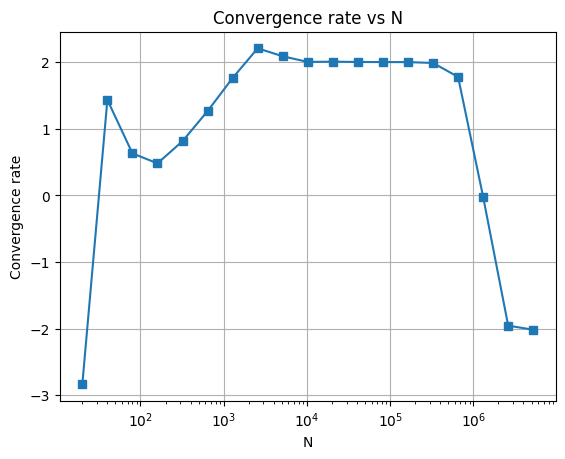

In [9]:
# Problem domain
omega = [0, 1]
u_a = 1
u_b = 0

# Problem data
alpha = lambda x : 0.001*np.ones(len(x))
beta = lambda x : np.ones(len(x))
gamma = lambda x : np.zeros(len(x))
rhs = lambda x : np.zeros(len(x))

# Grid parameters
N = 5
x = np.linspace(omega[0],omega[1],N+1)

# Assemble FD system
A, F = FD1DNH(omega,N,alpha,beta,gamma,rhs,u_a,u_b)
uh1 = sp.linalg.spsolve(A,F)
h1 = (omega[1]-omega[0])/N
plt.plot(x,uh1)
plt.show()

N = N*2
A, F = FD1DNH(omega,N,alpha,beta,gamma,rhs,u_a,u_b)
uh2 = sp.linalg.spsolve(A,F)
h2 = (omega[1]-omega[0])/N
x = np.linspace(omega[0],omega[1],N+1)
plt.plot(x,uh2)
plt.show()


err1 = max(abs(uh1-uh2[[2*i for i in range(N//2+1)]]))

uh1 = uh2
h1 = h2

errors = []
errors.append(err1)
rates = []
Ns = [N]

no_exp = 20
# loop over remaining experiments
for i in range(no_exp-1):
  # fix the mesh
  N = 2 * N
  x =np.linspace(omega[0],omega[1],N+1)
  # evaluate system for given N
  A, F = FD1DNH(omega,N,alpha,beta,gamma,rhs,u_a,u_b)
  # Solve
  uh2 = sp.linalg.spsolve(A,F)
  plt.plot(x,uh2)
  plt.show()

  err2 = max(abs(uh1-uh2[[2*i for i in range(N//2 + 1)]]))
  h2 = (omega[1]-omega[0])/N
  rate = (np.log(err1)-np.log(err2))/(np.log(h1)-np.log(h2))
  errors.append(err2)
  rates.append(rate)
  Ns.append(N)
  # Update
  err1=err2
  h1=h2
  uh1=uh2


for i in range(len(rates)):
   print("N:",Ns[i+1], " Error:", errors[i+1], " Rate:", rates[i])

import matplotlib.pyplot as plt
plt.figure()
plt.loglog(Ns, errors, marker='o')
plt.xlabel('N')
plt.ylabel('Error')
plt.title('Error vs N')
plt.grid(True, which='both')

plt.figure()
plt.plot(Ns[1:], rates, marker='s')
plt.xlabel('N')
plt.ylabel('Convergence rate')
plt.title('Convergence rate vs N')
plt.grid(True)
plt.xscale('log')
plt.show()
